# Understand factors that influence Airbnb price at Boston

`Goal`: Understand what factors are influencing Airbnb listing price at Boston and build a simple model to predict price. Some specific questions:
1. What are the top factors?
2. Which neighbourhood has the highest listing price?
3. Which amenities are adding the most value to the listing?

In [399]:
import numpy as np
import pandas as pd
import math
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option("max_columns", None)

In [400]:
#read linstings data 
listings = pd.read_csv("listings.csv")

In [401]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

The question I am interested in is what influence the Airbnb price at Boston. For example, which neighbourhood has the most expensive listings. Let's build a simple model to understand.

## 1. Data Cleaning

### 1.1 Remove Columns

First, look like some features are not very useful in predicting prices such as url. I am going to remove useless columns. To simply the problems a bit, let's only keep non-text columns as well. There are some columns with all missing variable or with only one value in the column, let's remove them as well.

In [402]:
##remove id or url columns
listings_clean = listings.drop(["id","listing_url","scrape_id","thumbnail_url","medium_url","picture_url",\
              "xl_picture_url","host_url","host_name","host_thumbnail_url","host_picture_url","host_id"], axis = 1)

##remove columns with all missing and one value 
listings_clean = listings_clean.drop(["experiences_offered","neighbourhood_group_cleansed","country","country_code","state",\
              "calendar_last_scraped","last_scraped","has_availability","license","jurisdiction_names","square_feet","market",\
                                     "host_has_profile_pic","requires_license"], axis = 1)


##remove text columns
listings_clean = listings_clean.drop(["name","summary","space","description","neighborhood_overview","notes","transit","access","interaction",\
             "house_rules","host_about","street","host_location","host_verifications","calendar_updated"], axis = 1)

##remove longtitude and latitude columns
listings_clean = listings_clean.drop(['latitude','longitude'], axis = 1)

##remove weekly price and monthly price since we want to predict daily price 
listings_clean = listings_clean.drop(['weekly_price','monthly_price'], axis = 1)

##remove columns columns with too many levels and unclean column
listings_clean = listings_clean.drop(["zipcode","neighbourhood","host_neighbourhood","smart_location"], axis = 1)

In [403]:
print(listings_clean.shape)

(3585, 46)


We are 46 columns left after cleanup.

### 2. Transform to right data types

Clean up columns with dollar sign.

In [404]:
dollar_columns = ['security_deposit','price','cleaning_fee','extra_people']

for col in dollar_columns:
    listings_clean[col] = listings_clean[col].map(lambda x: int(str(x)[1:-3].replace(",","")) if type(x) == str else np.nan)

Clean up columns with percentage

In [405]:
percent_columns = ["host_response_rate","host_acceptance_rate"]

for col in percent_columns:
    listings_clean[col] = listings_clean[col].map(lambda x: float(x.rstrip("%"))/100 if type(x) == str else np.nan)

Clean up date column to calculate the days from date when the data was scraped.

In [406]:
date_columns = ['host_since','first_review','last_review']

for col in date_columns:
    listings_clean[col] = listings_clean[col].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d") if type(x) == str else None)

In [407]:
current_date = datetime.datetime.strptime('9/7/2016', "%m/%d/%Y")

In [408]:
listings_clean['days_since_last_review'] = listings_clean['last_review'].map(lambda x: (current_date - x).days)
listings_clean['days_since_first_review'] = listings_clean['first_review'].map(lambda x: (current_date - x).days)
listings_clean['days_since_first_host'] = listings_clean['host_since'].map(lambda x: (current_date - x).days)

In [409]:
#drop date columns 
listings_clean = listings_clean.drop(['host_since','first_review','last_review'],axis = 1)

In [410]:
##convert columns to boolean
for tf_feature in ['host_is_superhost', 'host_identity_verified',
                   'is_location_exact', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    listings_clean[tf_feature] = listings_clean[tf_feature].map(lambda s: False if s == "f" else True)

### 3. Transform amenities data to a list of binary column

In [411]:
def cleanup_json_array(column, data = listings_clean):
    """
    INPUT
    data - original dataframe 
    column - column name for the column in json format 
    OUTPUT 
    dataframe with transform column 
    """
    #clean up amenities column
    data[column] = data[column].map(lambda amns: [amn.replace("}","").replace("{","").replace('"','') for amn in amns.split(",")])

    ##join multiple array together 
    amenities = np.unique(np.concatenate(data[column], axis = None))

    ##delete empty value
    amenities = np.delete(amenities,0)


    ##convert a list of values to a set of binary columns 
    amenities_matrix = np.array([data[column].map(lambda amns: x in amns).values for x in amenities])

    ##transform to data frame
    amenities_df = pd.DataFrame(np.transpose(amenities_matrix), columns = amenities)

    ##merge with original data frames
    listings_merged = pd.concat([data, amenities_df], axis = 1).drop("amenities", axis = 1)
    
    return listings_merged

In [412]:
listings_merged = cleanup_json_array('amenities',listings_clean)

In [413]:
listings_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 90 columns):
host_response_time                            3114 non-null object
host_response_rate                            3114 non-null float64
host_acceptance_rate                          3114 non-null float64
host_is_superhost                             3585 non-null bool
host_listings_count                           3585 non-null int64
host_total_listings_count                     3585 non-null int64
host_identity_verified                        3585 non-null bool
neighbourhood_cleansed                        3585 non-null object
city                                          3583 non-null object
is_location_exact                             3585 non-null bool
property_type                                 3582 non-null object
room_type                                     3585 non-null object
accommodates                                  3585 non-null int64
bathrooms                    

## 2. Data Understanding

After cleanup, we have 90 columns

In [414]:
print("Columns with numeric values:", listings_merged.select_dtypes(include = ['float64','int64']).shape[1])
print("Columns with boolean values:", listings_merged.select_dtypes(include = ['bool']).shape[1])
print("Columns with categorical values:", listings_merged.select_dtypes(include = ['object']).shape[1])

Columns with numeric values: 32
Columns with boolean values: 51
Columns with categorical values: 7


In [415]:
(listings_merged.isnull().sum()/len(listings_merged)).sort_values(ascending = False)

security_deposit                    0.625662
cleaning_fee                        0.308787
review_scores_accuracy              0.229568
review_scores_location              0.229289
review_scores_value                 0.229010
review_scores_checkin               0.228731
review_scores_communication         0.228173
review_scores_cleanliness           0.228173
review_scores_rating                0.226778
days_since_first_review             0.210879
days_since_last_review              0.210879
reviews_per_month                   0.210879
host_response_time                  0.131381
host_response_rate                  0.131381
host_acceptance_rate                0.131381
bathrooms                           0.003905
bedrooms                            0.002789
beds                                0.002510
property_type                       0.000837
city                                0.000558
accommodates                        0.000000
host_is_superhost                   0.000000
host_ident

There are 20 columns with at least one missing value and 12 columns with more than 20% missing values.

## 3. Data Exploration 

### 3.1 Explore price variable

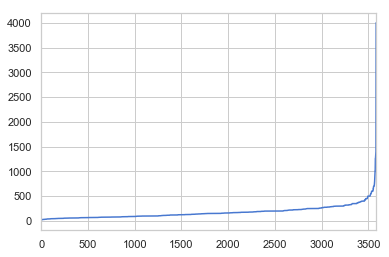

In [416]:
listings_merged['price'].sort_values().reset_index(drop=True).plot()

We noticed some rental lists with extremely high price, which will throw off our model if we include. So let's cap all the prices at 600.

In [417]:
listings_merged['price'] = np.where(listings_merged['price'] > 600, 600, listings_merged['price'])

### 3.2 Data Exploration for Numeric Predictor

#### 3.2.1 Explore and impute columns with missing values

In [418]:
listings_merged.select_dtypes(include = ['float64','int64']).isnull().mean().sort_values(ascending = False)

security_deposit                  0.625662
cleaning_fee                      0.308787
review_scores_accuracy            0.229568
review_scores_location            0.229289
review_scores_value               0.229010
review_scores_checkin             0.228731
review_scores_communication       0.228173
review_scores_cleanliness         0.228173
review_scores_rating              0.226778
reviews_per_month                 0.210879
days_since_first_review           0.210879
days_since_last_review            0.210879
host_response_rate                0.131381
host_acceptance_rate              0.131381
bathrooms                         0.003905
bedrooms                          0.002789
beds                              0.002510
host_total_listings_count         0.000000
accommodates                      0.000000
price                             0.000000
host_listings_count               0.000000
days_since_first_host             0.000000
guests_included                   0.000000
extra_peopl

security_deposit and cleaning_fee are top two columns with missing values. They are missing as not every host requires security deposite and cleaning fee for their listings. So we set it to zero when it's missing.

Another groups of missing columns is review related columns. They are missing when the listing doesn't have any review. We have a column that tracks number of reviews. Number of reviews is equal to zero whenever review_scores_rating is missing. Since number of reviews already capture the effect of missing reviews. We impute review_scores related feature with median.

In [419]:
listings_merged['security_deposit'] = listings_merged['security_deposit'].fillna(0)
listings_merged['cleaning_fee'] = listings_merged['cleaning_fee'].fillna(0)

In [420]:
review_cols = ['review_scores_accuracy','review_scores_location','review_scores_value','review_scores_checkin',\
              'review_scores_communication','review_scores_cleanliness','review_scores_rating','days_since_last_review',\
              'reviews_per_month','days_since_first_review','host_response_rate','host_acceptance_rate']

listings_merged[review_cols] = listings_merged[review_cols].apply(lambda col: col.fillna(col.median()))

For columns related to the capacity of the listing,we impute missing value with mode since it's an ordinal variable and 1 is the most frequent value.

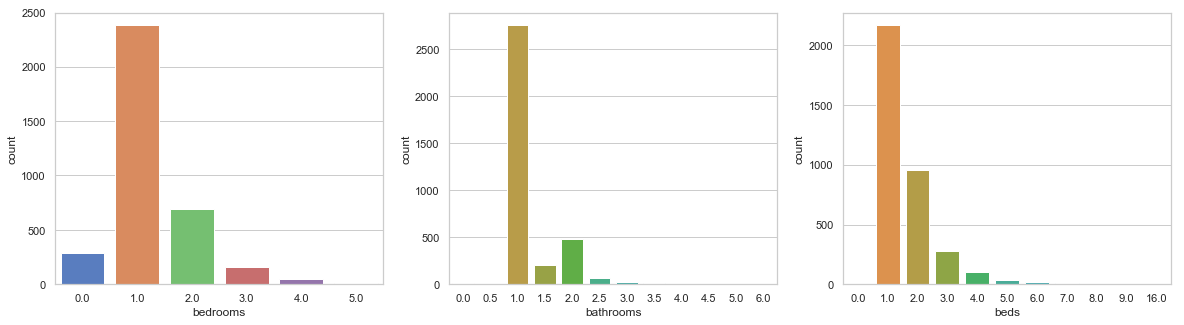

In [421]:
f, axes = plt.subplots(1,3, figsize=(20,5))
sns.countplot(x = 'bedrooms', data = listings_merged, ax = axes[0])
sns.countplot(x = 'bathrooms', data = listings_merged, ax = axes[1])
sns.countplot(x = 'beds', data = listings_merged, ax = axes[2])

In [422]:
mode_columns = ['bedrooms','bathrooms','beds']
listings_merged[mode_columns] = listings_merged[mode_columns].apply(lambda col: col.fillna(1.0))

#### 3.2.1 Data Visualization for Numeric Variables

In [423]:
listings_merged.select_dtypes(include = ['float64','int64']).corr()['price'].sort_values()

host_acceptance_rate             -0.157856
reviews_per_month                -0.148823
number_of_reviews                -0.111558
maximum_nights                   -0.006762
review_scores_value               0.000508
host_response_rate                0.000767
minimum_nights                    0.003263
review_scores_checkin             0.008297
review_scores_communication       0.015336
extra_people                      0.032293
review_scores_accuracy            0.051115
availability_365                  0.052005
days_since_first_review           0.070423
days_since_last_review            0.081618
review_scores_rating              0.095481
days_since_first_host             0.112185
availability_90                   0.143429
review_scores_cleanliness         0.143675
availability_60                   0.162602
review_scores_location            0.182837
availability_30                   0.185354
security_deposit                  0.197648
calculated_host_listings_count    0.232421
host_total_

We can tell features with postive correlation with price tend to be size-related features such as how many people can the place accommodates, bedrooms and beds.It's also surprising that acceptance rate and reviews per month are negatively correlated with price. My hypothesis is that home owners who set a lower price tend be less selective of guest profile and cheaper listings attract more guests as well so have more reviews in general.

Next we look at the some visualizations for each feature.

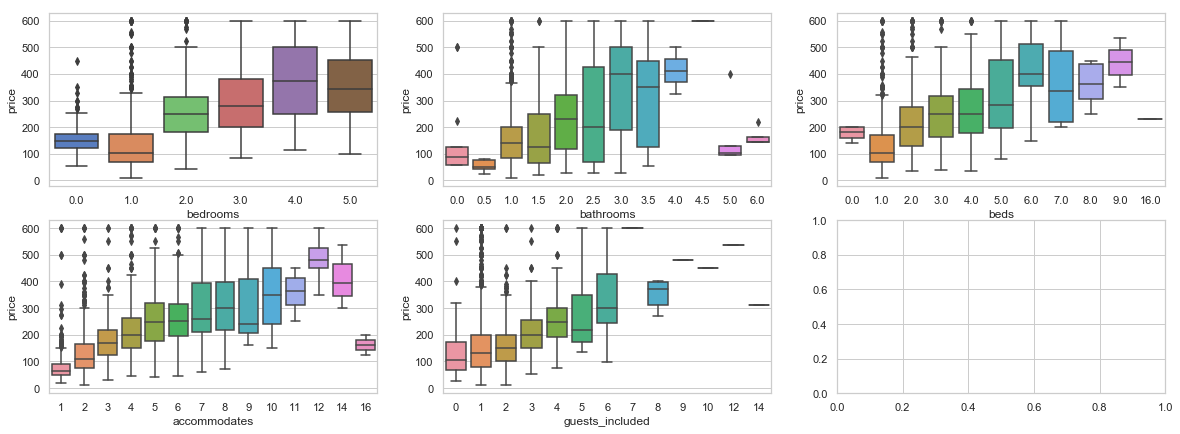

In [424]:
#feature related to size of the property
f, axes = plt.subplots(2,3, figsize=(20,7))
sns.set(style="whitegrid", palette="muted")
sns.boxplot(y='price', x='bedrooms', data = listings_merged, ax = axes[0][0])
sns.boxplot(y='price', x='bathrooms', data = listings_merged, ax = axes[0][1])
sns.boxplot(y='price', x='beds', data = listings_merged, ax = axes[0][2])
sns.boxplot(y='price', x='accommodates', data = listings_merged, ax = axes[1][0])
sns.boxplot(y='price', x='guests_included', data = listings_merged, ax = axes[1][1])

Price is in general positively correlated with number of bedrooms, bathrooms, beds, accommodates and guests.

In [425]:
review_columns = ["days_since_last_review","days_since_first_review","host_acceptance_rate","review_scores_rating",\
                 "review_scores_accuracy"]

listing_review = listings_merged[review_columns]

for x in review_columns:
    listing_review[x + '_bucketed'] = pd.qcut(listings_merged[x].rank(method = 'first'), 10, labels = range(10))

/Users/stacyli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


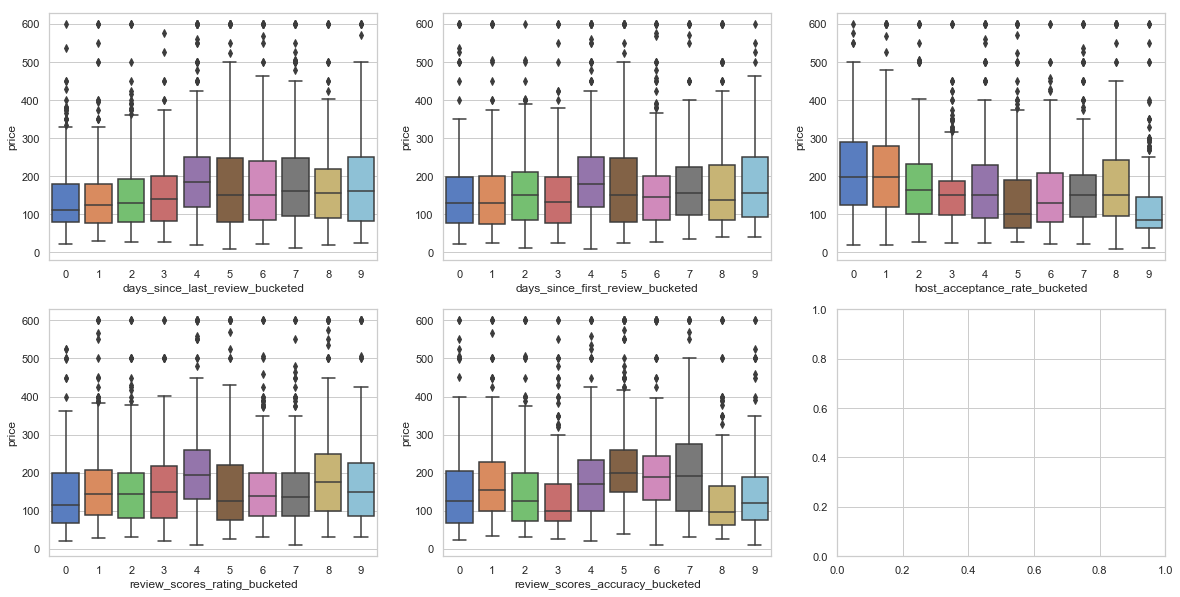

In [426]:
sns.set(style="whitegrid", palette="muted")
f, axes = plt.subplots(2,3, figsize=(20,10))

for com in zip(axes.flatten()[:5], review_columns):
    sns.boxplot(y=listings_merged['price'], x=com[1]+'_bucketed', data = listing_review, ax = com[0])

Only acceptance rate seems to be correlated with price with a negative relationship.

#### 3.2.2 Data Exploration - boolean features 

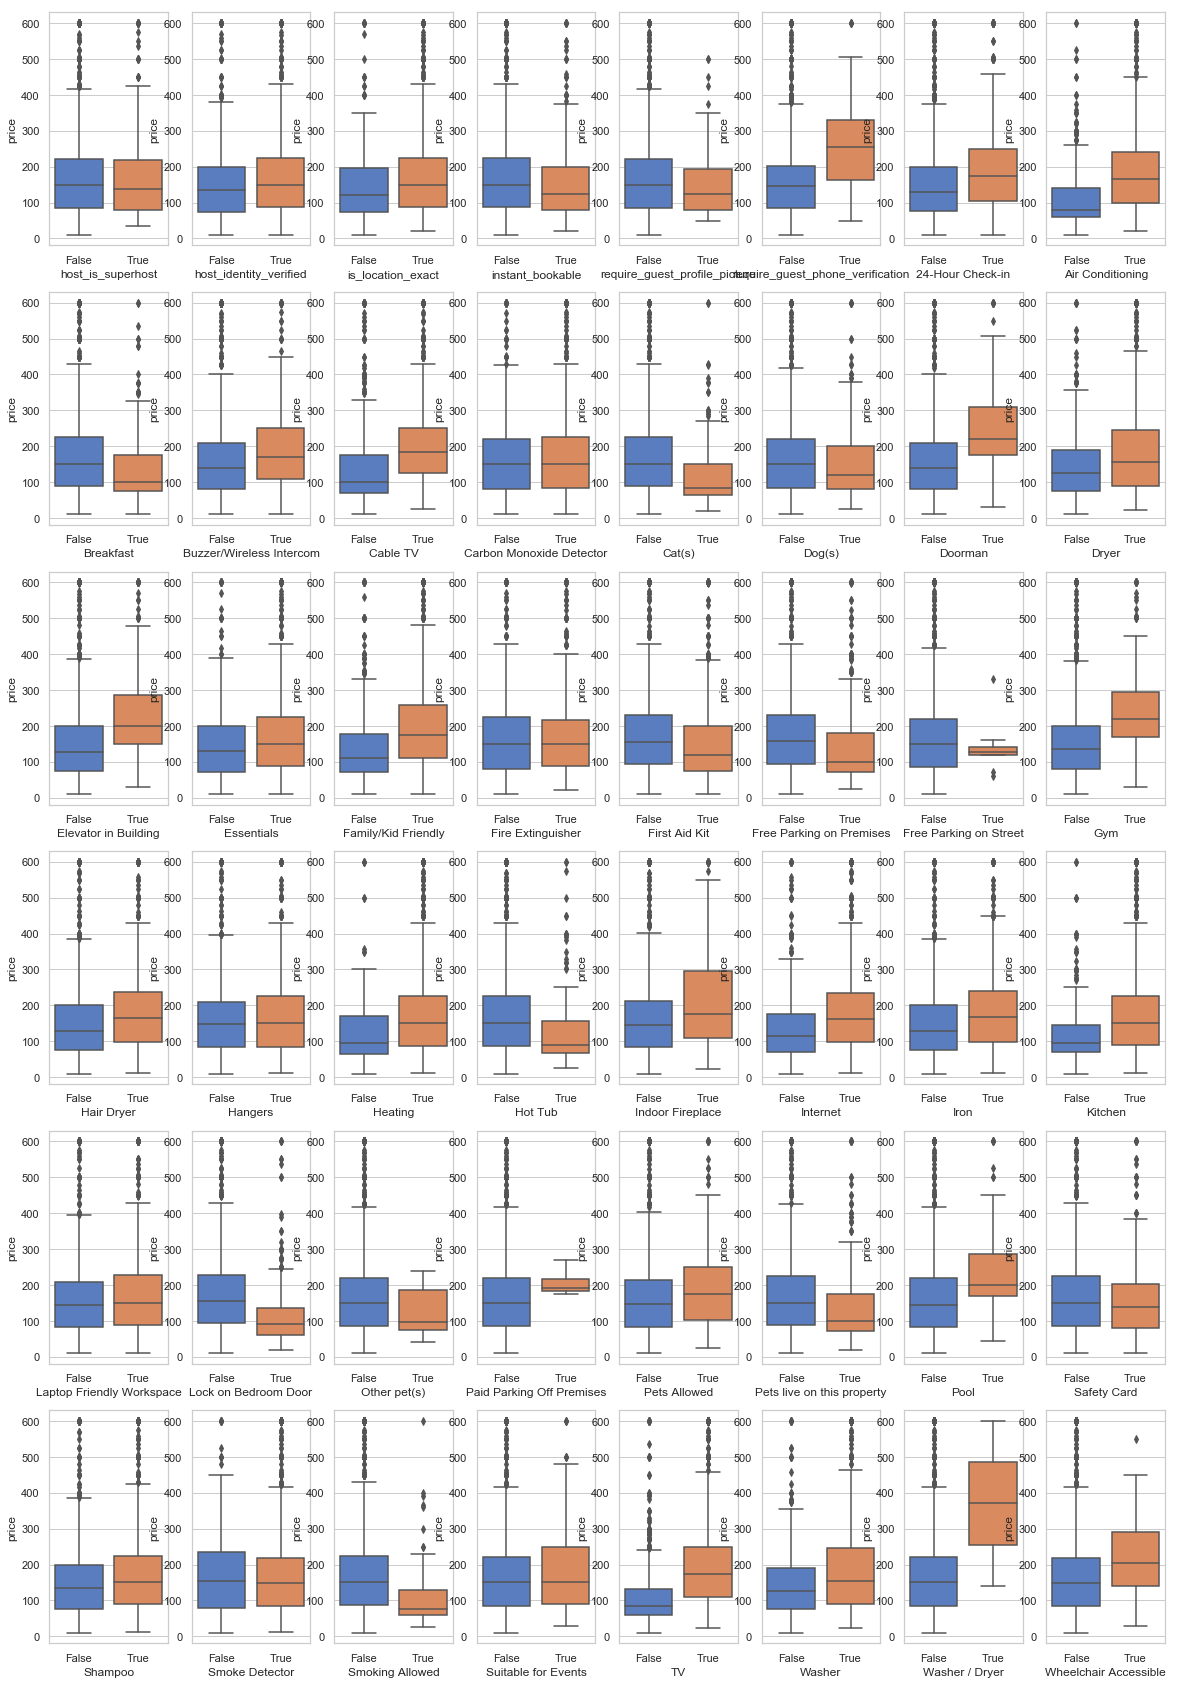

In [357]:
sns.set(style="whitegrid", palette="muted")
f, axes = plt.subplots(6,8, figsize=(20,30))

bool_col = listings_merged.select_dtypes(include = ['bool']).columns
for com in zip(axes.flatten()[:51], bool_col):
    sns.boxplot(y='price', x=com[1], data = listings_merged, ax = com[0])

Look like a few amenities such as washer/dryer, pool and doorman are positivly correlated with listing price.

In [433]:
listings_merged.select_dtypes(include = ['bool']).isnull().sum()>0

host_is_superhost                             False
host_identity_verified                        False
is_location_exact                             False
instant_bookable                              False
require_guest_profile_picture                 False
require_guest_phone_verification              False
24-Hour Check-in                              False
Air Conditioning                              False
Breakfast                                     False
Buzzer/Wireless Intercom                      False
Cable TV                                      False
Carbon Monoxide Detector                      False
Cat(s)                                        False
Dog(s)                                        False
Doorman                                       False
Dryer                                         False
Elevator in Building                          False
Essentials                                    False
Family/Kid Friendly                           False
Fire Extingu

There is no missing valye in boolean columns.

#### 3.2.3 Data Exploration - Categorical features

In [434]:
def plot_cat_feature(variable, data = listings_merged):
    """
    INPUT 
    variable - name of categorical var to visualize
    data - dataframe that contain X and Y to visualize 
    
    OUTPUT 
    a boxplot visualization 
    """
    plt.figure(figsize=(20,5))
    sort_order = listings_merged\
                .groupby(variable)['price']\
                .median()\
                .sort_values(ascending=False)\
                .index
    sns.boxplot(y='price', x=variable, data = data, order = sort_order)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

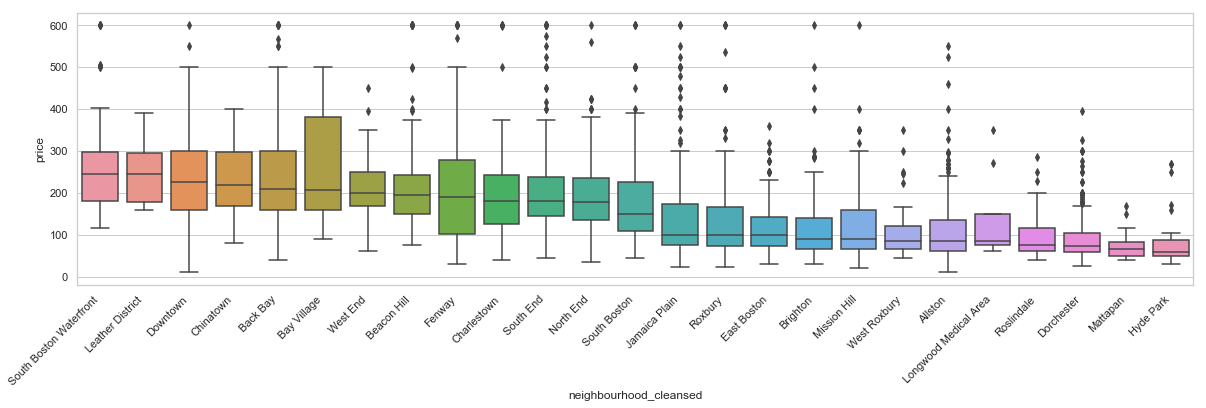

In [435]:
plot_cat_feature('neighbourhood_cleansed', listings_merged)

Price varies greatly in different neighbourhoods.

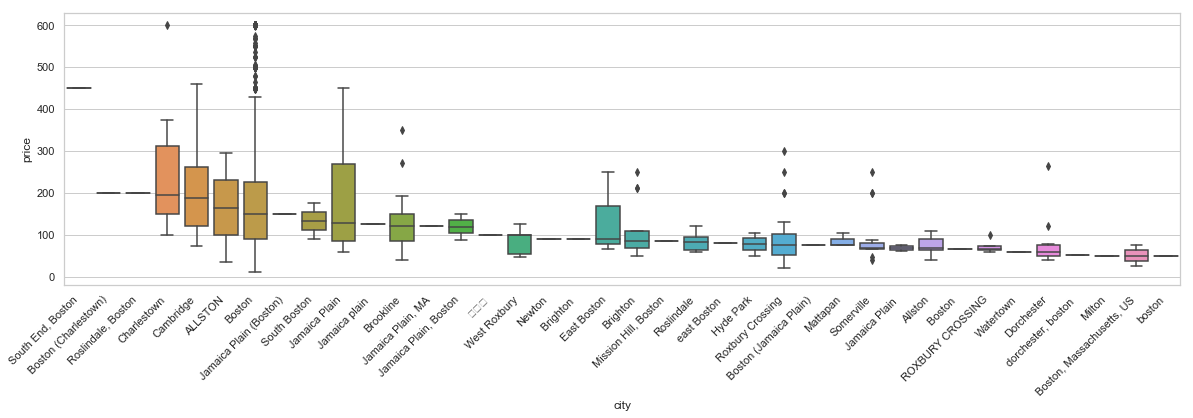

In [436]:
plot_cat_feature('city', listings_merged)

Look like city column is not very clean: it seems to have duplicates such as Boston(Charlestown) and Charlestown.Since we already have cleaned neighbourhood, let's drop city field.

In [437]:
listings_merged = listings_merged.drop('city', axis = 1)

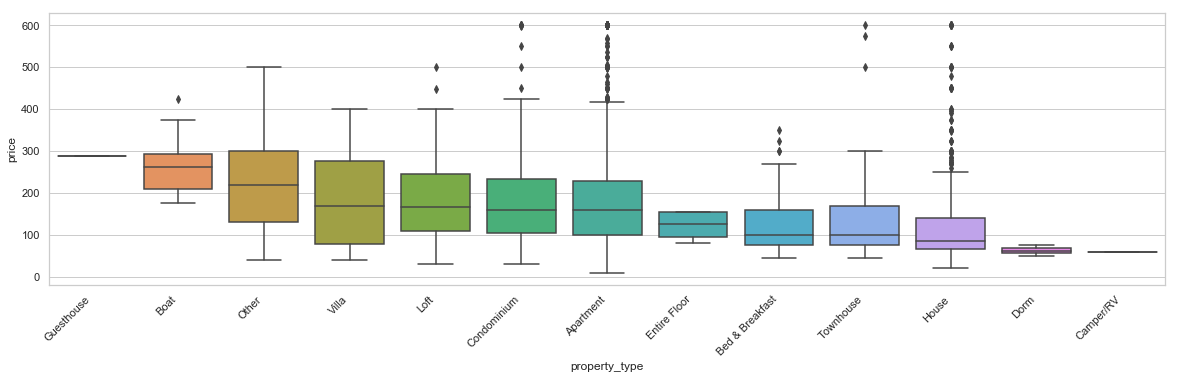

In [438]:
plot_cat_feature('property_type', listings_merged)

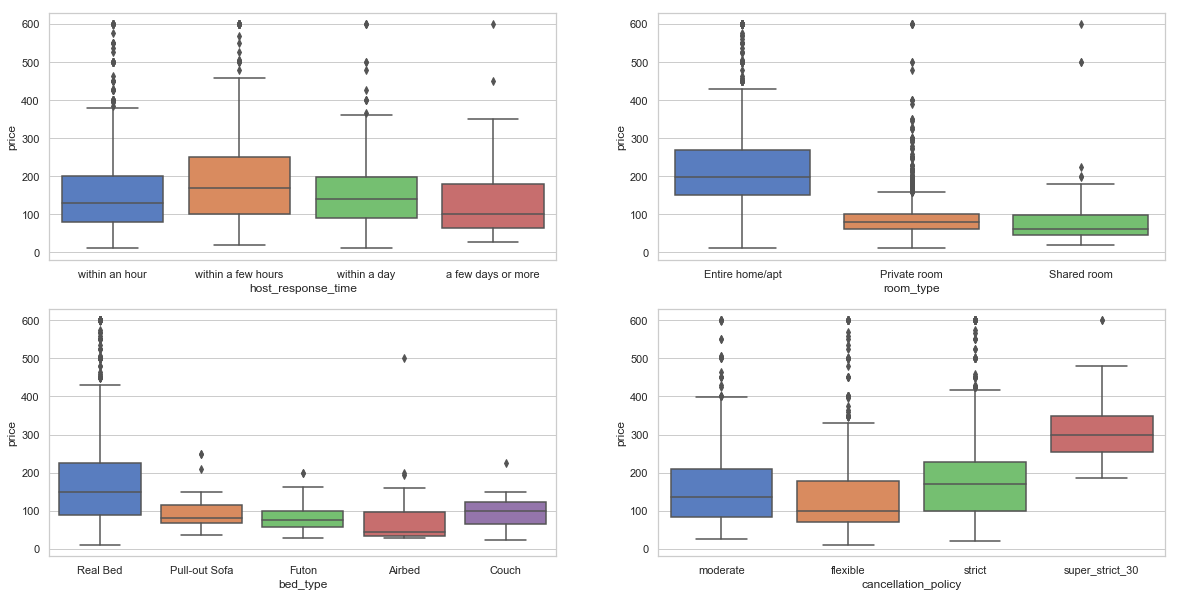

In [439]:
f, axes = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(y='price', x='host_response_time', data = listings_merged, ax = axes[0][0])
sns.boxplot(y='price', x='room_type', data = listings_merged, ax = axes[0][1])
sns.boxplot(y='price', x='bed_type', data = listings_merged, ax = axes[1][0])
sns.boxplot(y='price', x='cancellation_policy', data = listings_merged, ax = axes[1][1])

First observation is that listing price is dependant on room type and bed type. Second observation is that cancellation policy is correlated with price: the higher the price, the stricter the cancellation, which makes sense. Higher price of listing comes with higher price of vacancy.

Let's check missing values in categorical columns.

In [450]:
listings_merged.select_dtypes(include = ['object']).isnull().sum()/len(listings_merged)

host_response_time        0.131381
neighbourhood_cleansed    0.000000
property_type             0.000837
room_type                 0.000000
bed_type                  0.000000
cancellation_policy       0.000000
dtype: float64

In [446]:
listings_merged['host_response_time'].value_counts()

within an hour        1384
within a few hours    1218
within a day           469
a few days or more      43
Name: host_response_time, dtype: int64

host_response_time column has 471 missing values (14%) and property_type has 3 missing values. Let's impute these two columns with mode as it works well with categorical.

In [365]:
listings_merged['host_response_time'] = listings_merged['host_response_time'].fillna(listings_merged['host_response_time'].mode()[0])

In [366]:
listings_merged['property_type'] = listings_merged['property_type'].fillna(listings_merged['property_type'].mode()[0])

## 4. Prepare data for Regression

In [367]:
from sklearn.cross_validation import train_test_split

In [368]:
#create dummy columns from categorical variables
category_dummies = pd.get_dummies(listings_merged.select_dtypes(include = ['object']))

In [369]:
listings_final = pd.concat([listings_merged.select_dtypes(exclude = ['object']),category_dummies],axis = 1)

In [370]:
X = listings_final.drop('price', axis='columns')
Y = listings_final['price']

In [371]:
#split training and testing test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 31)

In [372]:
print('Training Set Size:', X_train.shape)
print('Training Set Size:', X_test.shape)

Training Set Size: (2509, 136)
Training Set Size: (1076, 136)


## 5. Try Lasso Regression

There are more than 100 variabels in the final dataset and we only have 2509 observation in training row, the model is likely to overfit. Let's use lasso to avoid overfitting.

In [373]:
from sklearn.linear_model import Lasso

In [374]:
def get_lasso_model_result(X_train, X_test, y_train, y_test, alpha, normalize = True):
    """
    INPUT
    X_train - predictors from training set 
    X_test - predictors from testing set
    alpha - alpha parameter for lasso model,
    normalize - if normalize input data
    
    OUTPUT
    A list of rmse and r^2 from training and testing set as well as featured ended up in model for a given alpha.
    
    This function is to build a lasso model for each given parameter and record the model evaluation metrics 
    as well as number of features used in a list
    
    """
    
    #build a lasso model with given parameters
    lasso = Lasso(alpha=alpha, max_iter=10e5, normalize = normalize)
    lasso.fit(X_train, y_train)
    
    #prediction
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    
    #RMSE
    mse_train = sklearn.metrics.mean_squared_error(y_train, y_train_pred)
    mse_test = sklearn.metrics.mean_squared_error(y_test, y_test_pred)
    root_train_mse = mse_train**(1/2)
    root_test_mse = mse_test**(1/2)
    
    #R^2
    r_squared_train = sklearn.metrics.r2_score(y_train, y_train_pred)
    r_squared_test = sklearn.metrics.r2_score(y_test, y_test_pred)
    
    
    #number of features used 
    coeff_used = np.sum(lasso.coef_!=0)
    
    return [root_train_mse, root_test_mse, r_squared_train, r_squared_test, coeff_used]

In [375]:
alpha_range = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
results = dict()

for alpha in alpha_range:
    results[str(alpha)] = get_lasso_model_result(X_train, X_test, y_train, y_test, alpha, True)

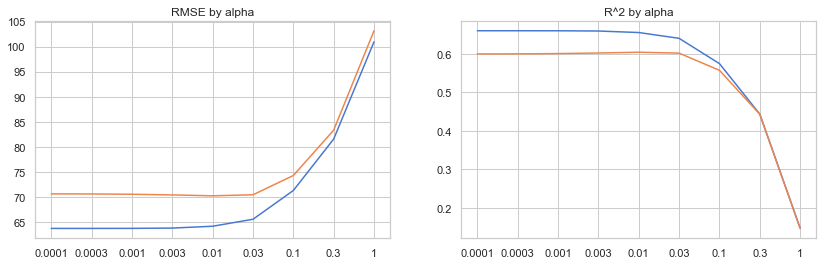

In [376]:
plt.figure(figsize=(14, 4))

#plot rmse plot
plt.subplot(121)
plt.title('RMSE by alpha')
plt.plot([key for key, value in results.items()], [value[0] for key, value in results.items()])
plt.plot([key for key, value in results.items()], [value[1] for key, value in results.items()])

#plot r^2 plot
plt.subplot(122)
plt.title('R^2 by alpha')
plt.plot([key for key, value in results.items()], [value[2] for key, value in results.items()])
plt.plot([key for key, value in results.items()], [value[3] for key, value in results.items()])

In [377]:
optimal_alpha = 0
optimal_test_r2 = 0
features_used = 0

for key, value in results.items():
    if value[3] > optimal_test_r2:
        optimal_test_r2 = value[3]
        optimal_alpha = key
        features_used = value[4]
    else:
        continue
print("Optimal Alpha for the model is:", optimal_alpha)
print("Optimal RMSE for the testingset is:", optimal_test_r2)
print("Number of features in optimal model:", features_used)

Optimal Alpha for the model is: 0.01
Optimal RMSE for the testingset is: 0.604582555123
Number of features in optimal model: 104


In [378]:
lasso = Lasso(alpha=0.01, max_iter=10e5, normalize = True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [379]:
coefs = sorted(list(zip(listings_final.drop('price', axis='columns').columns,lasso.coef_)), key=lambda x:x[1], reverse = True)

In [380]:
##top 10 positive factors
coefs[:10]

[('Washer / Dryer', 90.979570830041567),
 ('cancellation_policy_super_strict_30', 66.400917055599976),
 ('neighbourhood_cleansed_South Boston Waterfront', 61.113899663660284),
 ('neighbourhood_cleansed_Back Bay', 53.983347178628861),
 ('room_type_Entire home/apt', 53.578169605973443),
 ('neighbourhood_cleansed_Beacon Hill', 51.791910161350351),
 ('neighbourhood_cleansed_Bay Village', 51.636610532791835),
 ('property_type_Boat', 51.152135288841777),
 ('neighbourhood_cleansed_Downtown', 43.08902335126372),
 ('bedrooms', 35.281586940521457)]

In [381]:
coefs[-10:]

[('Other pet(s)', -23.439496109489596),
 ('neighbourhood_cleansed_Jamaica Plain', -24.64730445825964),
 ('neighbourhood_cleansed_Brighton', -25.797881354807036),
 ('property_type_Entire Floor', -36.72467430490444),
 ('neighbourhood_cleansed_Dorchester', -39.515875885685709),
 ('neighbourhood_cleansed_Hyde Park', -43.81998815220512),
 ('neighbourhood_cleansed_Mattapan', -44.311205428259825),
 ('neighbourhood_cleansed_West Roxbury', -44.357071640709357),
 ('neighbourhood_cleansed_Roslindale', -49.368481697021096),
 ('property_type_Camper/RV', -116.57785855478997)]

### Summary

Now answers to our questions become clearer. 
**My first question was what the top factors that influence price for listing are.** From the absolute coefficient of the lasso model, we can tell property type, room type, neighbourhood and amenities are the top predictors. Although strict cancellation policy also shows up as top predictor, it seems to be the result of high price of listing. Hosts need to endure greater loss if expensive listings get cancelled.

It's surprising to me that RVs tend to have a lower price than normal listings and I didn't even know you can rent a boat on Aibrnb. 

In terms of amenities, Washer/Dryer is the only one that made it to the top 10 list. Listings with washer/dryer on average are $91 more expensive than the listing without them. Washer/Dryer certainly add value to the listing themselve but I think it's also because washer/dryer are more likely to exist in new apartments or houses, which are usually more expensive.

South Boston Waterfront is the most expensive neighbourhood, followed by Back Bay, Beacon Hill and Bay Village. 

Entire home/apt also tends to have a higher price, which is aligned with common sense.

In [459]:
coefs_df = pd.DataFrame(coefs, columns = ['cariable','coefs'])
coefs_df['abs_coefs'] = np.abs(coefs_df['coefs'])

In [463]:
coefs_df.sort_values('abs_coefs', ascending = False).head(10)

,cariable,coefs,abs_coefs
135,property_type_Camper/RV,-116.577859,116.577859
0,Washer / Dryer,90.979571,90.979571
1,cancellation_policy_super_strict_30,66.400917,66.400917
2,neighbourhood_cleansed_South Boston Waterfront,61.113900,61.113900
3,neighbourhood_cleansed_Back Bay,53.983347,53.983347
4,room_type_Entire home/apt,53.578170,53.578170
5,neighbourhood_cleansed_Beacon Hill,51.791910,51.791910
6,neighbourhood_cleansed_Bay Village,51.636611,51.636611
7,property_type_Boat,51.152135,51.152135
134,neighbourhood_cleansed_Roslindale,-49.368482,49.368482


**For my second question: Which neighbourhood has the highest listing price?.** Let's take a detailed look at the coefficient by neighbourhood.

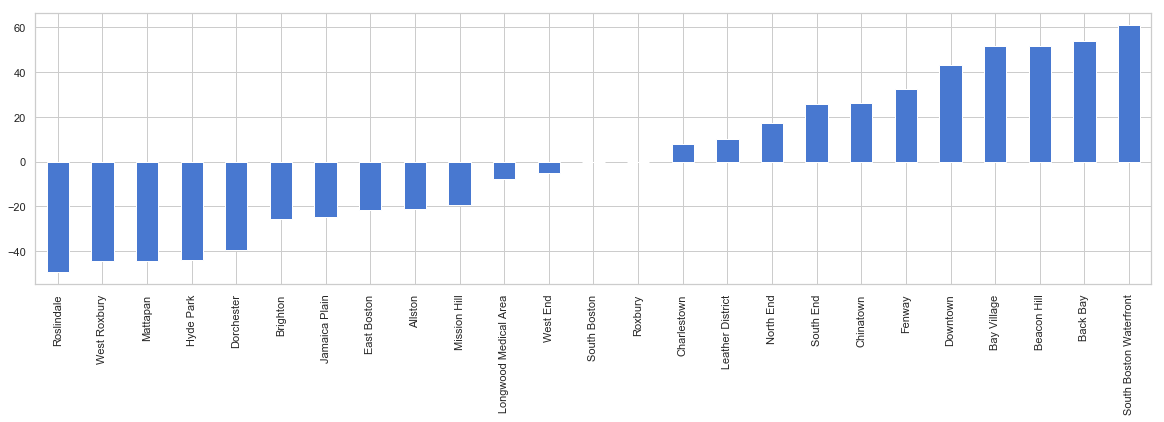

In [464]:
neighborhoods = np.unique(listings_merged['neighbourhood_cleansed'])
neighborhood_effects = [v for v in coefs if v[0].replace('neighbourhood_cleansed_','') in neighborhoods]

plt.figure(figsize=(20,5))
pd.Series(data=[n[1] for n in neighborhood_effects],
          index=[n[0].replace('neighbourhood_cleansed_','') for n in neighborhood_effects])\
    .sort_values()\
    .plot(kind='bar')

We can well neighbourhoods near downtown and Boston harbour area have the most expensive listings while city that are farther away from city center such as Rosilindale, West Roxbury and Mattapan have the cheapest listings.

**For my second question: Which amenities are adding the most value to the listing?.** Let's take a detailed look at the coefficient by amenities as well.

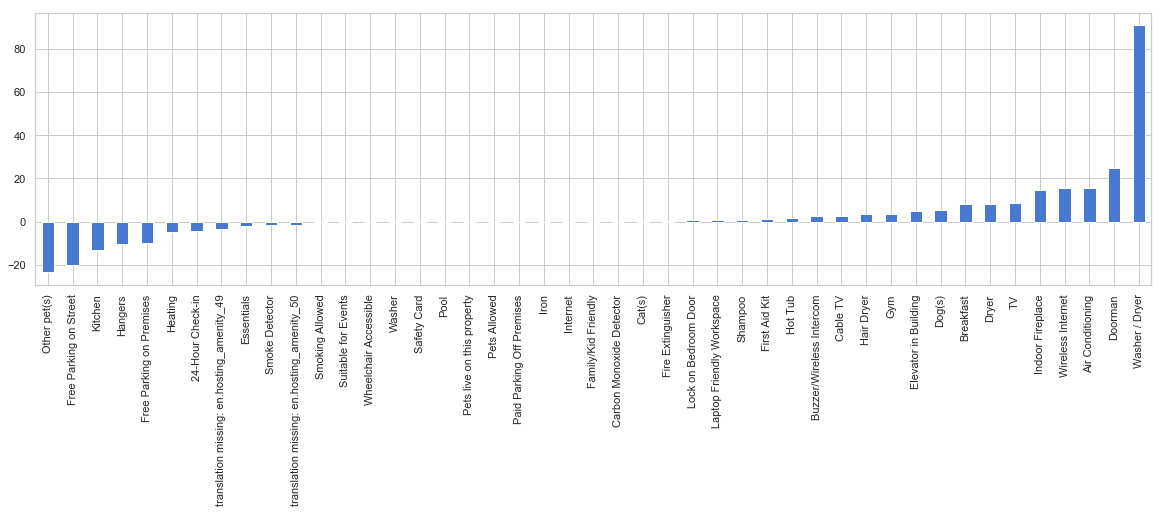

In [466]:
amenity_effects = [v for v in coefs if v[0] in amenities]

plt.figure(figsize=(20,5))
pd.Series(data=[n[1] for n in amenity_effects],
          index=[n[0] for n in amenity_effects])\
    .sort_values()\
    .plot(kind='bar')

Top 5 amenities that are adding value to listings are Washer/Dryer, Doorman, AC, WIFI and indoor fireplace. Top 5 amenities with negative effect on the listing prices are Other pets(s), free parking on the street, kitchen, hangers, and free parking on premises. These are an interesting case. Sometimes what a host chooses to list as an amenity is a signal about the "class" of the listing. One example is hanger. We usually just assume every listing has hangers; hosts who choose to list them as a "feature" anyway bring up the shade of not having such a rather basic necessity, which actually signals a lower price.